In [5]:
import zipfile
import os

# ZIP dosyanın Colab içindeki yolu (Dosyanı yüklediğin yer burası olmalı)
zip_path = "/content/drive/MyDrive/Beyin_Verileri_Teknofest_2021/beyin_verileri.zip"

# ZIP dosyasını çıkaracağımız hedef klasör
extract_path = "/content/beyin_verileri"

# ZIP dosyasını çıkar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Kendi klasörünü oluştur

print("ZIP dosyası çıkarıldı.")

# Çıkarılan klasör içeriğini kontrol et
print(os.listdir(extract_path))
print("Train klasörü:", os.listdir(os.path.join(extract_path, "train")))
print("Val klasörü:", os.listdir(os.path.join(extract_path, "val")))
print("Test klasörü:", os.listdir(os.path.join(extract_path, "test")))

ZIP dosyası çıkarıldı.
['train', 'test', 'val']
Train klasörü: ['inme_var', 'inme_yok']
Val klasörü: ['inme_var', 'inme_yok']
Test klasörü: ['inme_var', 'inme_yok']


In [6]:
import numpy as np
import cv2
import os
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils import shuffle

# EfficientNetB4 için uygun görüntü boyutu
img_size = (380, 380)

# Veri yükleme fonksiyonu (EfficientNetB4 için)
def load_dataset(dataset_type="train", limit=None):
    X, Y = [], []
    classes = ["inme_var", "inme_yok"]

    dataset_path = f"/content/beyin_verileri/{dataset_type}"

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path '{dataset_path}' not found!")

    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)

        if not os.path.exists(class_path):
            print(f"Warning: Class path '{class_path}' not found! Skipping...")
            continue

        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.png')]

        if not image_files:
            print(f"Warning: No images found in {class_path}")

        if limit:
            image_files = image_files[:limit]

        for file in image_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: Could not read image {file}. Skipping...")
                continue

            # Gri tonlamalıyı 3 kanallıya çevir
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            # EfficientNetB4 boyutuna yeniden boyutlandır
            img = cv2.resize(img, img_size)

            # Normalizasyon (0-1 arasına getir)
            img = img / 255.0

            X.append(img)
            Y.append(label)

    # Numpy dizisine çevir
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.int32)

    return X, Y

# EfficientNetB4 için Train, Validation ve Test veri setlerini yükleme
X_train, Y_train = load_dataset("train")
X_val, Y_val = load_dataset("val")
X_test, Y_test = load_dataset("test")

# Veri boyutlarını kontrol et
print(f"Train Set: {X_train.shape}, Labels: {Y_train.shape}")
print(f"Validation Set: {X_val.shape}, Labels: {Y_val.shape}")
print(f"Test Set: {X_test.shape}, Labels: {Y_test.shape}")

# Model eğitimi için veriler artık tamamen hazır!


Train Set: (4654, 380, 380, 3), Labels: (4654,)
Validation Set: (997, 380, 380, 3), Labels: (997,)
Test Set: (999, 380, 380, 3), Labels: (999,)


In [7]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback

# Google Drive içindeki kayıt klasörü
model_save_dir = "/content/drive/MyDrive/Model_Kayitlar/EfficientNetB4/"


# Callback'leri liste olarak tanımla
callbacks_list = [
    ModelCheckpoint(
        os.path.join(model_save_dir, "BestEfficientB4_model.keras"),  # En iyi modeli kaydet
        monitor="val_loss",  # Validasyon kaybını izle
        save_best_only=True,  # Sadece en iyi modeli kaydet
        save_weights_only=False,  # Modelin tamamını kaydet (ağırlıklar + yapı)
        mode="min",  # En düşük val_loss olduğunda kaydet
        verbose=1
    ),
    LambdaCallback(
        on_epoch_end=lambda epoch, logs: model.save(os.path.join(model_save_dir, f"model_epoch_{epoch+1:02d}.keras")) if (epoch + 1) % 25 == 0 else None
    ),
    EarlyStopping(
        monitor="val_loss",  # Validasyon kaybını izle
        patience=5,  # 5 epoch boyunca iyileşme olmazsa dur
        mode="min",  # En düşük val_loss değerini takip et
        verbose=1,
        restore_best_weights=True  # En iyi ağırlıklara geri dön
    ),
    ReduceLROnPlateau(
        monitor="val_loss",  # Validasyon kaybını izle
        factor=0.5,
        patience=5,  # 3 epoch boyunca iyileşme olmazsa azalt
        mode="min",  # En düşük val_loss değerini takip et
        verbose=1,
        min_lr=1e-6  # Minimum öğrenme hızı
    )
]


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


# EfficientNetB4 modeli yükleniyor (önceden eğitilmiş ImageNet ağırlıkları)
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(380, 380, 3))

# Feature extraction için modelin ana katmanlarını dondur
base_model.trainable = False

# Üstüne eklenebilecek katmanlar
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Özellik çıkarımı

# İlk Dense katmanı
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.4)(x)  # Overfitting önleme

# İkinci Dense katmanı
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)  # Overfitting önleme

# Üçüncü Dense katmanı
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)  # Overfitting önleme

# Çıkış katmanı (Binary Classification)
output_layer = Dense(1, activation="sigmoid")(x)

# Modeli oluştur
model = Model(inputs=base_model.input, outputs=output_layer)

# Feature Extraction aşaması için modelin derlenmesi
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy",metrics=["accuracy", Precision(), Recall()])

# Model özeti
model.summary()

# Feature Extraction aşaması (İlk eğitim, Dense katmanları eğitilir)
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=1000, batch_size=32,verbose=1,callbacks=callbacks_list)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 380, 380, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 380, 380, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 380, 380, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 380, 380, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 381, 381, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 190, 190, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 190, 190, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 190, 190, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 190, 190, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 190, 190, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 190, 190, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 18,759,776 (71.56 MB)

 Trainable params: 1,084,161 (4.14 MB)

 Non-trainable params: 17,675,615 (67.43 MB)

Epoch 1/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5394 - loss: 0.8794 - precision_2: 0.7042 - recall_2: 0.5372
Epoch 1: val_loss did not improve from 0.49113
146/146 ━━━━━━━━━━━━━━━━━━━━ 89s 320ms/step - accuracy: 0.5395 - loss: 0.8791 - precision_2: 0.7043 - recall_2: 0.5373 - val_accuracy: 0.6740 - val_loss: 0.6392 - val_precision_2: 0.6782 - val_recall_2: 0.9714 - learning_rate: 1.0000e-04
Epoch 2/1000
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5767 - loss: 0.7860 - precision_2: 0.7184 - recall_2: 0.5911
Epoch 2: val_loss did not improve from 0.49113
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.5769 - loss: 0.7859 - precision_2: 0.7185 - recall_2: 0.5914 - val_accuracy: 0.6851 - val_loss: 0.6052 - val_precision_2: 0.6971 - val_recall_2: 0.9322 - learning_rate: 1.0000e-04
Epoch 3/1000
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6040 - loss: 0.7345 - precision_2: 0.7265 - recall_2: 0.6391
Epoch 3: val_loss did not improve from 0

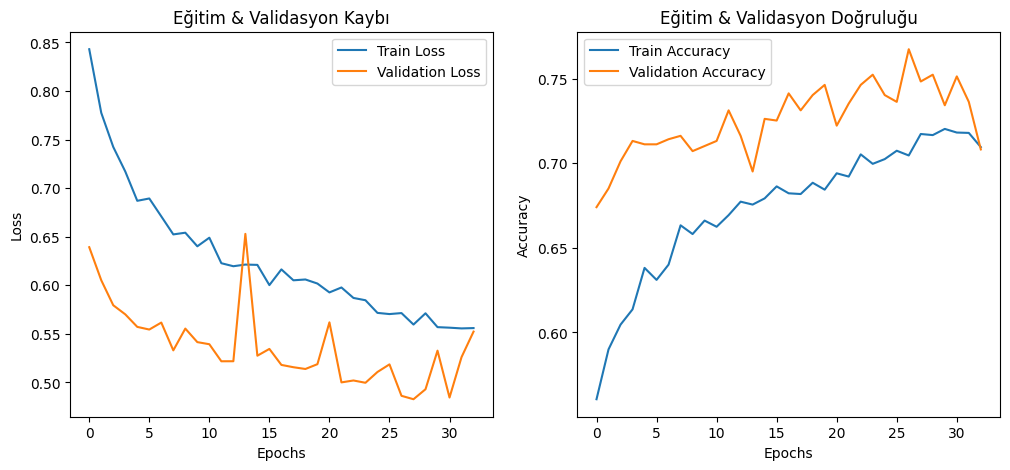

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Eğitim sonuçlarını al

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Grafik Çizme
plt.figure(figsize=(12, 5))

# Kayıp Grafiği
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim & Validasyon Kaybı")
plt.legend()

# Doğruluk Grafiği
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Eğitim & Validasyon Doğruluğu")
plt.legend()

plt.show()

In [15]:
# Test seti üzerinde modeli değerlendir
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, Y_test, verbose=1)

# Modelin tahminlerini al
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Sigmoid çıktısını sınıflara çevir

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6119 - loss: 0.6510 - precision_2: 0.4084 - recall_2: 0.6141
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Test Loss: 0.4998
Test Accuracy: 0.7518
Test Precision: 0.7733
Test Recall: 0.8872


In [16]:
# EfficientNetB4 modelinde ilk 200 katmanı DONDUR, geri kalanı aç
for layer in base_model.layers[:200]:  # İlk 200 katmanı dondur
    layer.trainable = False

for layer in base_model.layers[200:]:  # Son 264 katmanı aç
    layer.trainable = True

# Öğrenme oranını düşür
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Fine-Tuning eğitimi
fine_tune_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=32,callbacks=callbacks_list)


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6335 - loss: 0.7106 - precision_3: 0.6954 - recall_3: 0.8091
Epoch 1: val_loss did not improve from 0.48275
146/146 ━━━━━━━━━━━━━━━━━━━━ 188s 597ms/step - accuracy: 0.6335 - loss: 0.7106 - precision_3: 0.6954 - recall_3: 0.8090 - val_accuracy: 0.6841 - val_loss: 0.6720 - val_precision_3: 0.7361 - val_recall_3: 0.8193 - learning_rate: 1.0000e-05
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6623 - loss: 0.6610 - precision_3: 0.7187 - recall_3: 0.8174
Epoch 2: val_loss did not improve from 0.48275
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.6623 - loss: 0.6610 - precision_3: 0.7186 - recall_3: 0.8174 - val_accuracy: 0.7101 - val_loss: 0.5865 - val_precision_3: 0.7713 - val_recall_3: 0.8027 - learning_rate: 1.0000e-05
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6801 - loss: 0.6232 - precision_3: 0.7422 - recall_3: 0.8179
Epoch 3: val_loss did not improve from 0.4

In [17]:
# Test seti üzerinde modeli değerlendir
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, Y_test, verbose=1)

# Modelin tahminlerini al
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Sigmoid çıktısını sınıflara çevir

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8261 - loss: 0.3683 - precision_3: 0.5258 - recall_3: 0.6413
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step
Test Loss: 0.3118
Test Accuracy: 0.8689
Test Precision: 0.8938
Test Recall: 0.9113


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# EfficientNetB4 modeli yükleniyor (önceden eğitilmiş ImageNet ağırlıkları)
base_model2 = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(380, 380, 3))

# 🔥 İlk 150 katmanı dondur, geri kalanını eğit
for layer in base_model2.layers[:150]:
    layer.trainable = False  # İlk 150 katman DONMUŞ halde kalacak

for layer in base_model2.layers[150:]:
    layer.trainable = True  # Sonraki EfficientNet katmanları açıldı

# Üstüne eklenebilecek katmanlar
x = base_model2.output
x = GlobalAveragePooling2D()(x)  # Özellik çıkarımı

# İlk Dense katmanı
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.4)(x)  # Overfitting önleme

# İkinci Dense katmanı
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)  # Overfitting önleme

# Üçüncü Dense katmanı
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.3)(x)  # Overfitting önleme

# Çıkış katmanı (Binary Classification)
output_layer = Dense(1, activation="sigmoid")(x)

# 🔹 **DOĞRU MODEL OLUŞTURMA**
model2 = Model(inputs=base_model2.input, outputs=output_layer)  # ✅ **Düzeltildi**

# Öğrenme oranını ayarla
model2.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy", Precision(), Recall()])

# Model özeti
model2.summary()

# Model eğitimi (Dondurulmuş ilk 150 katman ile, geri kalan EfficientNet katmanları eğitiliyor)
history = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=1000, batch_size=32, callbacks=callbacks_list)

# Modelin değerlendirilmesi
test_loss, test_acc, test_prec, test_recall = model2.evaluate(X_test, Y_test)

# **DOĞRU SONUÇ YAZDIRMA**
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")  # ✅ **Düzeltildi**
print(f"Test Recall: {test_recall:.4f}")  # ✅ **Düzeltildi**


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 380, 380, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_10 (Rescaling)  │ (None, 380, 380, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_5           │ (None, 380, 380, 3)    │              7 │ rescaling_10[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_11 (Rescaling)  │ (None, 380, 380, 3)    │              0 │ normalization_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 381, 381, 3)    │              0 │ rescaling_11[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 190, 190, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 190, 190, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 190, 190, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 190, 190, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 190, 190, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 190, 190, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 18,759,776 (71.56 MB)

 Trainable params: 18,343,927 (69.98 MB)

 Non-trainable params: 415,849 (1.59 MB)

Epoch 1/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.5014 - loss: 0.9617 - precision_6: 0.6617 - recall_6: 0.5016
Epoch 1: val_loss did not improve from 0.30820
146/146 ━━━━━━━━━━━━━━━━━━━━ 186s 550ms/step - accuracy: 0.5015 - loss: 0.9616 - precision_6: 0.6619 - recall_6: 0.5016 - val_accuracy: 0.6690 - val_loss: 0.6394 - val_precision_6: 0.6687 - val_recall_6: 0.9970 - learning_rate: 1.0000e-05
Epoch 2/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5610 - loss: 0.8478 - precision_6: 0.7275 - recall_6: 0.5527
Epoch 2: val_loss did not improve from 0.30820
146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - accuracy: 0.5610 - loss: 0.8477 - precision_6: 0.7275 - recall_6: 0.5527 - val_accuracy: 0.6680 - val_loss: 0.6176 - val_precision_6: 0.7023 - val_recall_6: 0.8705 - learning_rate: 1.0000e-05
Epoch 3/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5852 - loss: 0.8045 - precision_6: 0.7388 - recall_6: 0.5701
Epoch 3: val_loss did not improve fr